In [1]:
using QuantumOptics, DiffEqNoiseProcess, PyPlot, Random, DelimitedFiles, NPZ, Printf, LinearAlgebra, DifferentialEquations, SpecialFunctions, SparseArrays, StatsBase, Optim, JLD2, BenchmarkTools
include("HenryLib.jl");

In [3]:
function smoothstep(x)
    if x < 0
        return 0
    elseif x > 1
        return 1
    else
        return 3*x^2 - 2*x^3
    end
end

smoothstep (generic function with 1 method)

In [19]:
using QuantumOptics, DiffEqNoiseProcess, PyPlot, DifferentialEquations, SparseArrays

Nspin = 10
κ = 2π*0.15 # MHz
Δc = 2π*20 # MHz
ωz = 2π*0.01 # MHz
seed = 1729
tmax = 50.0 # μs
recordtimes = 50
tspan = range(0.0, tmax, recordtimes)

sb = SpinBasis(Nspin // 2)
Sx = sigmax(sb) / 2
Sy = sigmay(sb) / 2
Sz = sigmaz(sb) / 2
idOp = identityoperator(sb)
ψ0 = spindown(sb)
ψ0 = normalize!(ψ0)
Q0 = 0 # charge on the photodiode at time 0
cl0 = ComplexF64[Q0]
ψ_sc0 = semiclassical.State(ψ0, cl0)

stateG = copy(ψ_sc0)
dstateG = copy(ψ_sc0)
Ntot = length(ψ_sc0.classical)+length(ψ_sc0.quantum)
u0 = zeros(ComplexF64, Ntot)
semiclassical.recast!(u0, ψ_sc0)

function recast_view!(state::semiclassical.State{B,T,C},x::C) where {B,T,C}
    N = length(state.quantum)
    state.quantum.data = view(x, 1:N)
    state.classical = view(x, N+1:length(state.classical))
end

function f_det(du, u, p, t)
    recast_view!(dstateG, du)
    recast_view!(stateG, u)
    # println(stateG.quantum.data)
    # println(parent(stateG.quantum.data))
    dstateG.quantum.data[1] = 0. 
    println(dstateG, "\n", du)

    semiclassical.recast!(du, dstateG)
    # println(u[1])
end

function g_noise(du, u, p, t)

end
A = rand(ComplexF64,Ntot)
B = rand(ComplexF64,Ntot)
f_det(A, B, 0., 0.)
print(A[1])

QuantumOptics.semiclassical.State{SpinBasis{5//1, Int64}, Ket{SpinBasis{5//1, Int64}, Vector{ComplexF64}}, Vector{ComplexF64}}(Ket(dim=11)
  basis: Spin(5)
                 0.0 + 0.0im
  0.6869198365451401 + 0.45874083811645394im
  0.2844436133031478 + 0.733845619337214im
   0.381777742081996 + 0.4774357432739505im
  0.8042497895536419 + 0.7409642572834446im
 0.22481916380871167 + 0.7509012660735721im
   0.678347842754043 + 0.7321152214916407im
 0.17072265622688176 + 0.02444226168654106im
 0.41468044117195146 + 0.09131569285936592im
   0.260759331324537 + 0.2965332351636272im
  0.2496527718685838 + 0.26558885282351896im, ComplexF64[])
ComplexF64[0.8322661157356993 + 0.8388013314539916im, 0.6869198365451401 + 0.45874083811645394im, 0.2844436133031478 + 0.733845619337214im, 0.381777742081996 + 0.47743574327395044im, 0.8042497895536419 + 0.7409642572834446im, 0.2248191638087117 + 0.7509012660735721im, 0.678347842754043 + 0.7321152214916407im, 0.17072265622688176 + 0.024442261686541067im, 

In [17]:
semiclassical.recast!

recast! (generic function with 15 methods)

In [21]:
gc = sqrt(ωz*(Δc^2 + κ^2)/abs(Nspin*Δc))
grel(t) = 1.0 #0.9*smoothstep(t/200.)

αplus = Δc/(-Δc + ωz - im*κ) + Δc/(-Δc - ωz - im*κ)
αminus = Δc/(-Δc + ωz - im*κ) - Δc/(-Δc - ωz - im*κ)

C(t) = (grel(t)*gc)*sqrt(κ)/(2*Δc)*(αplus*Sx+im*αminus*Sy)
H0(t) = ωz*Sz - (grel(t)*gc)^2/(4*Δc)*Sx*(2*real(αplus)*Sx-2*imag(αminus)*Sy)
H_nl(ψ,t) = im * expect(dagger(C(t)), normalize(ψ)) * C(t) - 0.5im * dagger(C(t)) * C(t) - 0.5im * expect(dagger(C(t)), normalize(ψ)) * expect(C(t), normalize(ψ)) * idOp
fdet_homodyne(t, ψ) = H0(t) + H_nl(ψ, t)
fst_homodyne(t, ψ) = [C(t) - expect(C(t), normalize(ψ)) * idOp]

Z1 = WienerProcess(0.0, im * 0.0, im * 0.0)
tout, psi_t_EM = my_schroedinger_dynamic(tspan, ψ0, fdet_homodyne, fst_homodyne; normalize_state=true, noise=Z1, seed=seed, alg=LambaEM(), dt=0.001, reltol=10^-4, abstol=10^-4, maxiters=10^8);


LoadError: UndefVarError: `check_schroedinger` not defined

In [15]:
diff = psi_t_SOSRI2[end] - psi_t_EM[end]
print(dagger(diff)*diff)

0.010472472731642386 + 9.356539586650395e-20im

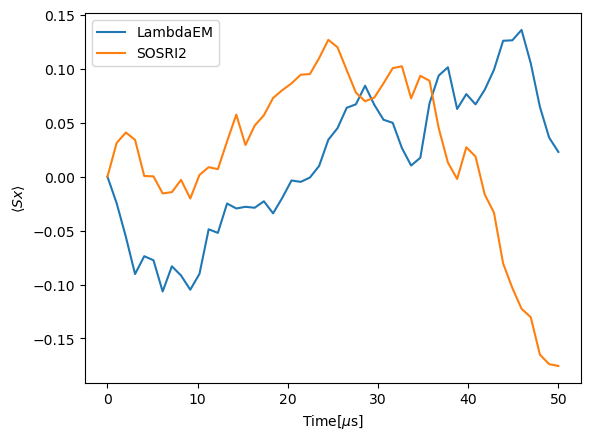

In [14]:
plot(tout, expect(Sx, psi_t_EM), label="LambdaEM")
plot(tout, expect(Sx, psi_t_SOSRI2), label="SOSRI2")
# plot(tout, 5/0.9*grel.(tout), linestyle="dashed")
legend()
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle Sx \\rangle\$")
PyPlot.display_figs()

In [52]:
using DiffEqNoiseProcess, SciMLBase, Plots
seed = 1337

Z1 = WienerProcess(0.0, im * 0.0, im * 0.0, reseed=false)
prob1 = NoiseProblem(Z1, (0.0, 10.0), seed=seed)
sol1 = solve(prob1; dt = 0.1)

Z2 = WienerProcess(0.0, im * 0.0, im * 0.0, reseed=false)
prob2 = NoiseProblem(Z2, (0.0, 10.0), seed=seed)
sol2 = solve(prob1; dt = 0.101);

plot(sol1.t, real.(sol1.u), label="Version 1")
Plots.savefig("V1.png")

plot(sol2.t, real.(sol2.u), label="Version 2")
Plots.savefig("V2.png");

"/Volumes/commondrive/Users/hshunt/LabNotebooks/DickeModel/V2.png"

In [6]:
(gc)^2/(4*Δc)

0.0015708846840882791

In [4]:
seed = Int(round(mod(time()*300,1000)))

280

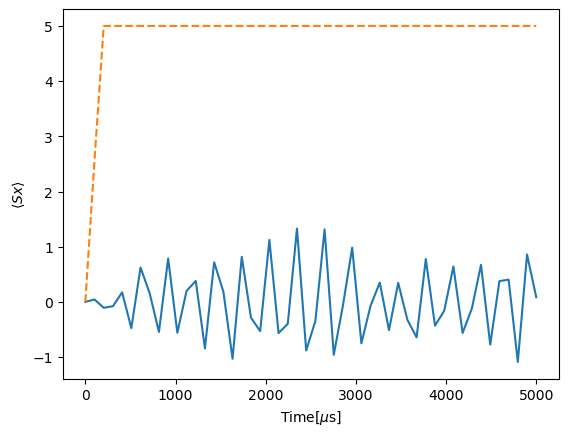

In [25]:
plot(tout, expect(Sx, psi_t))
plot(tout, 5/0.9*grel.(tout), linestyle="dashed")
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle Sx \\rangle\$")
PyPlot.display_figs()

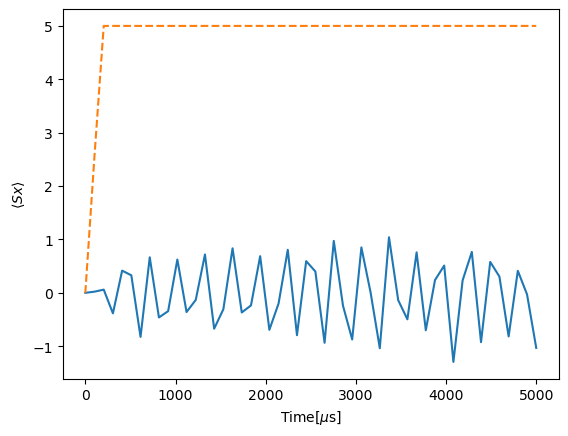

In [16]:
plot(tout, expect(Sx, psi_t))
plot(tout, 5/0.9*grel.(tout), linestyle="dashed")
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle Sx \\rangle\$")
PyPlot.display_figs()

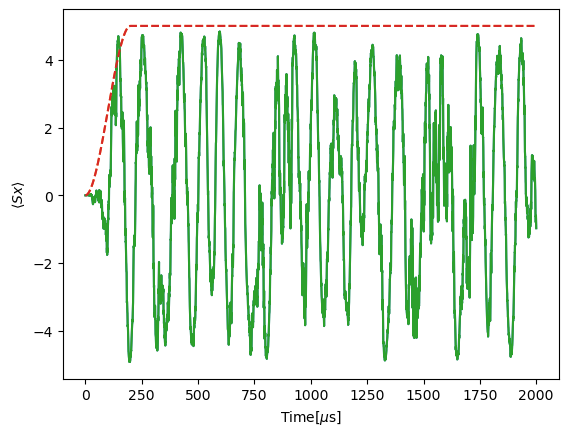

In [110]:
ax = gca()
ax.plot(tout, expect(Sx, psi_t))
ax.plot(tout, 5/0.9*λrelfnc.(tout), linestyle="dashed")
ax.set_xlabel("Time[\$\\mu\$s]")
ax.set_ylabel("\$\\langle Sx \\rangle\$")
PyPlot.display_figs()

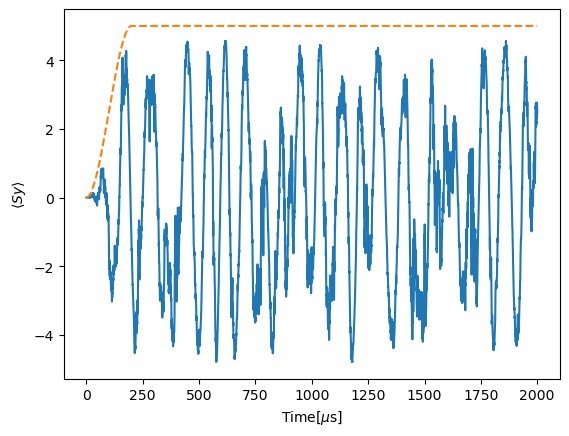

In [103]:
plot(tout, expect(Sy, psi_t))
plot(tout, 5/0.9*λrelfnc.(tout), linestyle="dashed")
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle Sy \\rangle\$")
PyPlot.display_figs()

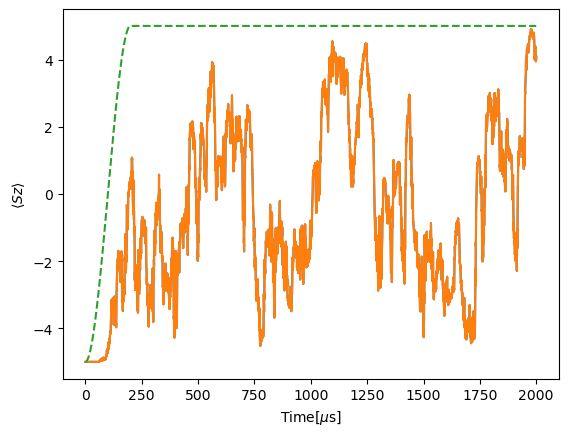

In [99]:
plot(tout, expect(Sz, psi_t))
plot(tout, 10/0.9*λrelfnc.(tout).-5, linestyle="dashed")
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle Sz \\rangle\$")
PyPlot.display_figs()

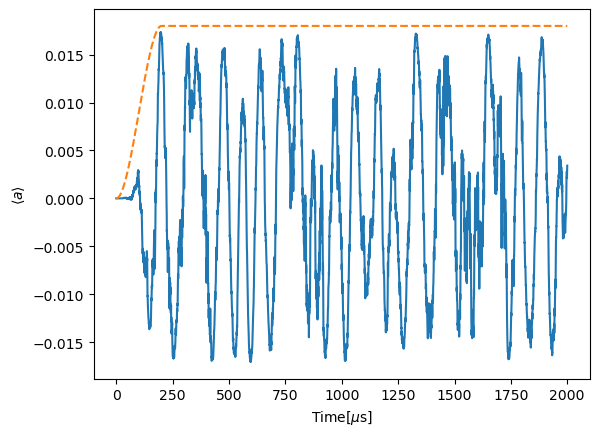

In [100]:
plot(tout, expect(a, psi_t))
plot(tout, 0.02*λrelfnc.(tout), linestyle="dashed")
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle a \\rangle\$")
PyPlot.display_figs()

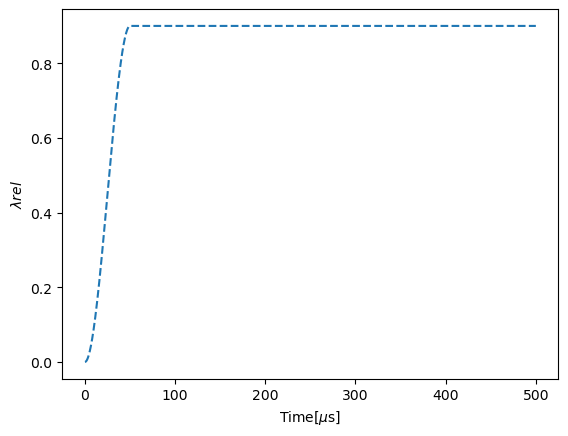

In [81]:
plot(tout, λrelfnc.(tout), linestyle="dashed")
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\lambda rel\$")
PyPlot.display_figs()

In [44]:
expect(Sz, psi_t)[1]

-50.0 + 0.0im

In [19]:
tout = load("DickeModelRslts4/seed=42lambda=1.034.jld2", "tout");
psi_t = load("DickeModelRslts4/seed=42lambda=1.034.jld2", "psi_t");
W = load("DickeModelRslts4/seed=42lambda=1.034.jld2", "W");

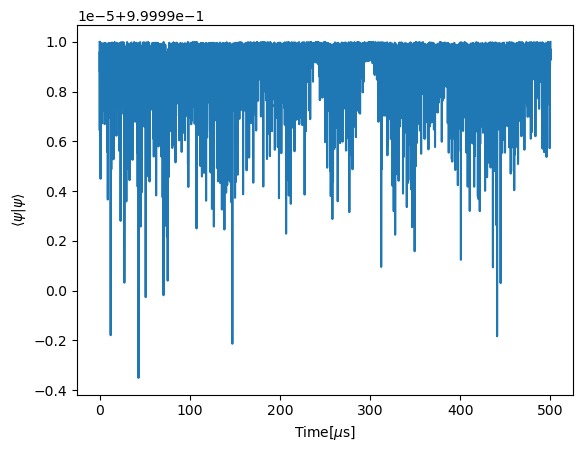

In [47]:
fb, sb, bases, a, Sx, Sy, Sz, idOp = make_operators(4, 100)
plot(tout, expect(idOp, psi_t))
xlabel("Time[\$\\mu\$s]")
ylabel("\$\\langle \\psi | \\psi \\rangle\$")
PyPlot.display_figs()

In [37]:
W(0.1)

(0.2384303867108135 - 0.3203593358009233im, -0.8781749128519063 - 0.20590953906942272im)

In [ ]:
white_noise = zeros(ComplexF64, length(tout))
prev_index = 1
new_index = 1
for i = 2:length(tout)
    new_index = prev_index
    while W.t[new_index] < tout[i]
        new_index += 1
    end
    white_noise[i] = (W.u[new_index] - W.u[prev_index])/(tout[i] - tout[i-1])
    prev_index = new_index
end

In [11]:
seed = 26
λrel = 1.0
κ=200.0

tout, psi_t, W, fb, sb, bases, a, Sx, Sy, Sz = single_run_dicke_hetrodyne(seed, λrel, κ=κ, tmax=500.0, Nspin=100);

Running with seed: 24

In [8]:
seed = 24
λrels = LinRange(0.0, 3.0, 30)
λrel = λrels[25]
tout = load("DickeModelRslts4/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2", "tout");
psi_t = load("DickeModelRslts4/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2", "psi_t");
W = load("DickeModelRslts4/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2", "W");

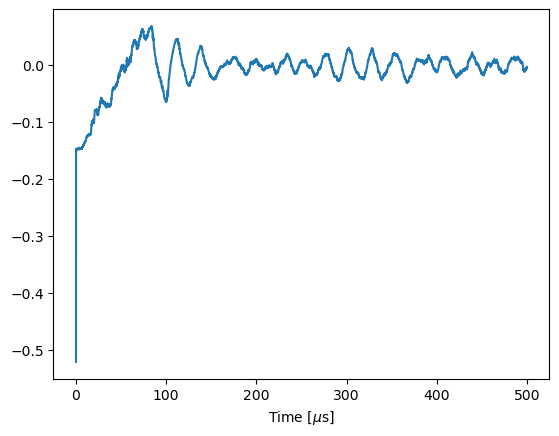

In [14]:
fb, sb, bases, a, Sx, Sy, Sz = make_operators(4, 100)
plot(tout, expect(a, psi_t))
xlabel("Time [\$\\mu\$s]")
ylabel("\$\\langle a \\rangle\$")
PyPlot.display_figs()

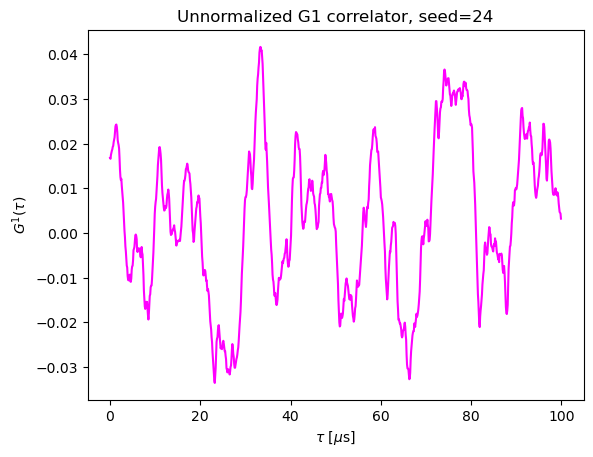

In [13]:
# seeds = [42, 1337, 1729, 724, 333, 137, 31459, 271828, 24, 240]
seed = 24
λrels = LinRange(0.0, 3.0, 30)
# short_list = λrels[1:7]
cm = get_cmap(:spring)
κ=200.0
fb, sb, bases, a, Sx, Sy, Sz = make_operators(4, 100)

for λrel in λrels[1:1]
    tout = load("DickeModelRslts4/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2", "tout");
    psi_t = load("DickeModelRslts4/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2", "psi_t");
    W = load("DickeModelRslts4/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2", "W");


    white_noise = zeros(ComplexF64, length(tout))
    prev_index = 1
    new_index = 1
    for i = 2:length(tout)
        new_index = prev_index
        while W.t[new_index] < tout[i]
            new_index += 1
        end
        white_noise[i] = (W.u[new_index] - W.u[prev_index])/(tout[i] - tout[i-1])
        prev_index = new_index
    end

    Jhet = sqrt(2*κ)*expect(a, psi_t) + conj(white_noise);
    dt = tout[2] - tout[1]
    tau = dt*10
    Jhetfilt = exp_filter(Jhet, tau, dt)
    time_bins = 1000
    time = tout[1:time_bins]

    Background = exp.(-time/tau)/(dt)*(1 - exp(-dt/tau))^2/(1 - exp(-2*dt/tau))

    # plot(time, two_point_correlator(Jhetfilt, tout, dt, time_bins))#  - Background
    # plot(time, Background)
    plot(time, two_point_correlator(Jhetfilt, tout, dt, time_bins) - Background, color=cm(λrel/λrels[end]), label="$(round(λrel,digits=2))")
    # plot(time, two_point_correlator(Jhetfilt, tout, dt, time_bins) - two_point_correlator(exp_filter(conj(white_noise), tau, dt), tout, dt, time_bins))
end
# legend()
xlabel(L"$\tau$ [$\mu$s]")
ylabel(L"$G^1 (\tau)$")
# PyPlot.colorbar()
PyPlot.title("Unnormalized G1 correlator, seed=$(seed)")
PyPlot.display_figs()

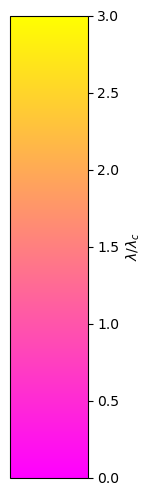

In [25]:
fig, ax = PyPlot.subplots(figsize=(1,6))
cm = get_cmap(:spring)
norm = matplotlib[:colors][:Normalize](vmin=0.0, vmax=3.0)
cb1 = matplotlib[:colorbar][:ColorbarBase](ax, cmap=cm, norm=norm)
cb1.set_label("\$\\lambda/\\lambda_c\$")
PyPlot.display_figs()

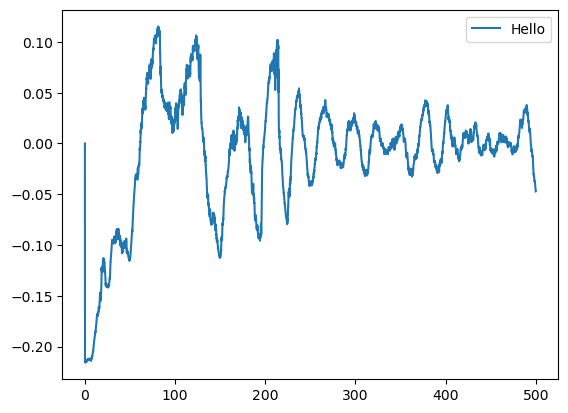

In [53]:
plot(tout, imag.(expect(a, psi_t)), label="Hello")
legend()
PyPlot.display_figs()

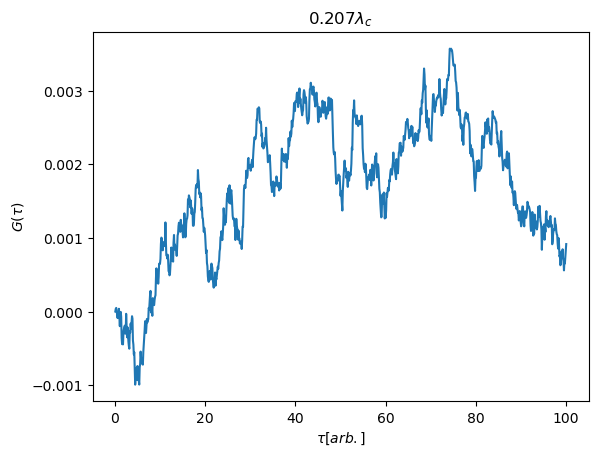

In [27]:
seeds = [42, 1337, 1729, 724, 333, 137, 31459, 271828, 24, 240]
seed = 42
λrel = 0.207
κ=200.0
tout = load("DickeModelRslts4/seed=$(seed)lambda=$(λrel).jld2", "tout");
psi_t = load("DickeModelRslts4/seed=$(seed)lambda=$(λrel).jld2", "psi_t");
W = load("DickeModelRslts4/seed=$(seed)lambda=$(λrel).jld2", "W");

white_noise = zeros(ComplexF64, length(tout))
prev_index = 1
new_index = 1
for i = 2:length(tout)
    new_index = prev_index
    while W.t[new_index] < tout[i]
        new_index += 1
    end
    white_noise[i] = (W.u[new_index] - W.u[prev_index])/(tout[i] - tout[i-1])
    prev_index = new_index
end

Jhet = sqrt(2*κ)*expect(a, psi_t) + conj(white_noise);
dt = tout[2] - tout[1]
tau = dt*1000
time_bins = 1000
time = dt*collect(1:time_bins)

Background = zeros(length(time))
Background[1] = 1/dt

# plot(time, two_point_correlator(Jhet, tout, dt, time_bins))#  - Background
# plot(time, Background)
plot(time, exp_filter(two_point_correlator(Jhet, tout, dt, time_bins) - Background, tau, dt))
# plot(time, two_point_correlator(Jhet, tout, dt, time_bins) - two_point_correlator(conj(white_noise), tout, dt, time_bins))
xlabel(L"\tau [arb.]")
ylabel(L"$G(\tau)$")
PyPlot.title("$(λrel)\$\\lambda_c\$")
PyPlot.display_figs()

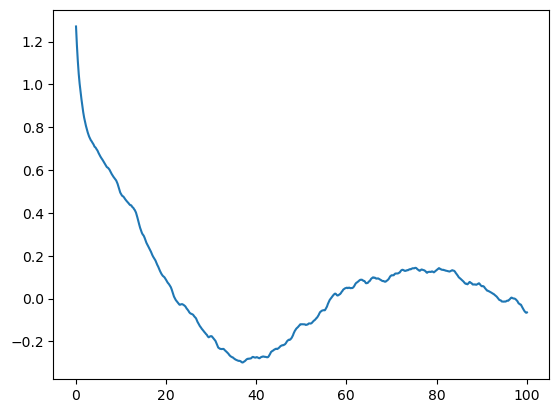

In [23]:
plot(time, two_point_correlator(Jhetfilt, tout, dt, time_bins) - two_point_correlator(exp_filter(conj(white_noise), tau, dt), tout, dt, time_bins))
PyPlot.display_figs()

In [70]:
two_point_correlator(Jhetfilt, tout, dt, 300)[2]

0.5062638157327481 + 0.00455229561347181im

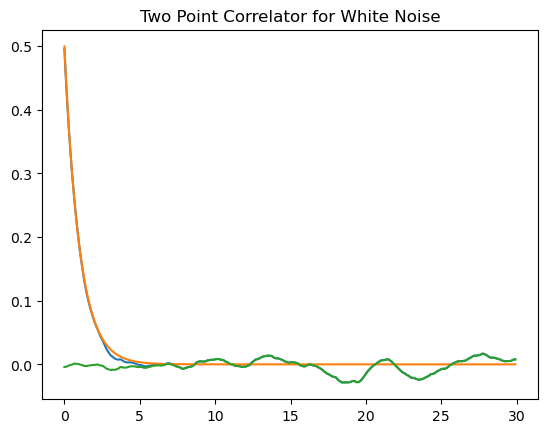

Pre-factor Actual: 0.49013553410966115-0.5106688003821964 	 Expected: 0.49953379120384234
 Decay time: 0.9883958362112918-1.050598005985766 	 Expected: 0.9999000000000001


In [10]:
W = WienerProcess(0.,im*0., im*0.)
time_total = LinRange(0.0,1000.0,10000)
time = time_total[1:300]
dt = time[2] - time[1]
tau = 10*dt
noise = make_white_noise(time_total, W)
filt_noise = exp_filter(noise, tau, dt)
Background = exp.(-time/tau)/dt*(1 - exp(-dt/tau))^2/(1 - exp(-2*dt/tau))
Bin_var = 1/dt

two_point = real.(two_point_correlator(filt_noise, time_total, dt, 300))

@. model(x,p) = p[1]*exp(-x*p[2])
fit = curve_fit(model, time,two_point, [1/(dt)*(1 - exp(-dt/tau))^2/(1 - exp(-2*dt/tau)), 1/tau])

Background = exp.(-time/tau)*(1/(dt)*(1 - exp(-dt/tau))^2/(1 - exp(-2*dt/tau)))

rslt = confidence_interval(fit, 0.1)
println("Pre-factor Actual: $(rslt[1][1])-$(rslt[1][2]) \t Expected: $(1/(dt)*(1 - exp(-dt/tau))^2/(1 - exp(-2*dt/tau)))\n Decay time: $(rslt[2][1])-$(rslt[2][2]) \t Expected: $(1/tau)")

# plot(time[1:300], two_point_correlator(noise, time, dt, 300))#  - Background
plot(time, two_point_correlator(filt_noise, time_total, dt, 300))
plot(time, Background)
# plot(time, two_point_correlator(noise, time_total, dt, 300))
# plot(time, Bin_var*ones(length(time)))
plot(time, two_point_correlator(filt_noise, time_total, dt, 300)-Background)
PyPlot.title("Two Point Correlator for White Noise")
PyPlot.display_figs()